# Magnetosphere region classification

In this notebook we study the performance of various classification
methods at identifying the region of the magnetosphere based on available measurements.

We will focus on using two features : 
- `r_n` : ion density normalized wrt solar wind (OMNI measurements)
- `r_b` : magnetic field magnitude normalized wrt solar wind (OMNI measurements)

In [1]:
import sys
import time
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import speasy as spz
import sklearn
import os
import pickle as pkl
from sklearn.metrics import *
from astropy import constants as Cst
from sklearn import preprocessing



# locally defined functions
from coord_utils import *
from plot_utils import *
import amda_utils

# default format for datetime objects
date_fmt="%Y-%m-%dT%H:%M:%S"
# excess time for interpolation
delta_t = timedelta(days=1)
# interpolation freq
freq = "60S"
# ACE data timeshift
shift_t = timedelta(seconds=4000)

We define some labels for each of classes we wish to detect as well as the associated color mapping.

In [2]:
# magnetoshere regions
region_labels = ["SW", "MgtSth", "MgtSph"]
# color mapping used
cmap = mpl.colors.ListedColormap(['r','g','b'])

Time range of the data used for training and testing the model. The data provided by AMDA has variable sampling time. We interpolate each feature with a fixed sampling time. To avoid side effect we retrieve data from `start - delta_t` to `stop + delta_t`. 

In [3]:
#start, stop = "2007-03-01T00:00:00", "2008-03-01T00:00:00"
start, stop = "2007-03-01T00:00:00", "2009-04-01T00:00:00"
start, stop = datetime.strptime(start, date_fmt), \
    datetime.strptime(stop, date_fmt)
# used for naming data file
start_str, stop_str = start.strftime(date_fmt),stop.strftime(date_fmt)
# start and stop for getting data
start_d, stop_d = start - delta_t, stop + delta_t

Ids of the parameters measured by the satellite:
- `sat_b_id` : id of the satellite's magnetic field measurements (GSE) (nT)
- `sat_n_id` : id of the satellite's ion density measurements 
- `sat_x_id` : id of the satellite's position data (GSE) (Re)

In [4]:
# Themis B - Prediction parameters
sat_b_id = "thb_bs" # magnetic field mesurements in GSE coordinates
sat_n_id = "thb_n_i" # plasma ion density
sat_x_id = "thb_xyz" # target position in GSE coordinates

# Themis A - prediction parameters
#target_b = "tha_bs"
#target_n = "tha_n_i"
#target_x = "tha_xyz"

Ids of the solar wind parameters : 
- `sw_b_id` : id of solar wind magnetic field measurements (GSE) (nT)
- `sw_n_id` : id of solar wind ion density measurements 
- `sw_v_id` : id of solar wind speed (GSE) (km/s)
- `sw_pdyn_id` : id of solar wind ram pressure (nP)

In [5]:
# Solar wind measurements (AMDA/OMNI data)
sw_b_id = "omni1_imf"
sw_n_id = "omni1_sw_n"
sw_v_id = "omni1_sw_vgse"
sw_pdyn_id = "omni1_sw_pdyn"

Get the interpolated data.

In [6]:
data_filename = f"parameter_data_{start_str}_{stop_str}.pkl"

parameter_ids = [sw_b_id,sw_n_id,sw_v_id,sw_pdyn_id] + \
                [sat_b_id, sat_n_id, sat_x_id]

m = len(parameter_ids)
parameter_shifts = {}#{"imf":shift_t, "sw_n":shift_t}

t, interpolated_data, bounds = amda_utils.get_interpolated_data(parameter_ids, 
                                    start_d,
                                    stop_d,
                                    data_filename, 
                                    shifts=parameter_shifts,
                                    freq=freq)

print(f"Interpolated data: ")
print(f"\tstart : {bounds[0]}")
print(f"\tstop  : {bounds[1]}")
print(f"\tfreq  : {freq}")
print(f"\tdata shapes")
for k,v in interpolated_data.items():
    print(f"\t\t{k}: {v.shape}")

Interpolated data: 
	start : 2007-03-07 17:55:11.289000
	stop  : 2009-03-31 16:20:17.648000
	freq  : 60S
	data shapes
		omni1_imf: (1087106, 3)
		omni1_sw_n: (1087106, 1)
		omni1_sw_vgse: (1087106, 3)
		omni1_sw_pdyn: (1087106, 1)
		thb_bs: (1087106, 3)
		thb_n_i: (1087106, 1)
		thb_xyz: (1087106, 3)
		thb_v_i_tot: (1087106, 1)


In [7]:
# Solar wind data calibration (not needed)
shift_sw_data = False
if shift_sw_data:
    # Relative position of ACE and current satellite in km
    rel_pos = (interpolated_data["ace_xyz_gse"] - interpolated_data[target_x]) * Cst.R_earth.value / 1000.
    # Solar wind speed measurement from ACE in km/s
    sw_v = interpolated_data["sw_v_gse"]
    # Time shift 
    time_shift = rel_pos[:,0] / sw_v[:,0]
    # new ACE solar wind time
    ace_time = t - time_shift
    print(f"Mean shift : {np.mean(time_shift)}")
    print(f"Min/max shift : {time_shift.min()}/{time_shift.max()}")
    print(f"Std shift  : {np.std(time_shift)}")

    # ACE Solar wind density and magnetic field interpolation
    for p in ["sw_n","imf","sw_v_gse","sw_pdyn"]:
        interp_data[p+"_shift"] = interp1d(ace_time, interpolated_data[p], axis=0, bounds_error=False)
        interpolated_data[p+"_shift"] = interp_data[p+"_shift"](t)
        # remove nans
        interpolated_data[p+"_shift"] = clean_data(interpolated_data[p+"_shift"])

Set asside the solar wind parameters for later use.

In [8]:
# Solar wind data
sw_n = interpolated_data[sw_n_id]
sw_b = interpolated_data[sw_b_id]
sw_v = interpolated_data[sw_v_id]
sw_pdyn = interpolated_data[sw_pdyn_id]

And the satellite measurements.

In [9]:
# Satellite measurements
sat_n = interpolated_data[sat_n_id]
sat_b = interpolated_data[sat_b_id]
sat_xyz = interpolated_data[sat_x_id]

## Feature analysis

Let's check out the data. The two features we are interested in are:
- `r_b` = $|b_{sat}|  /  |b_{sat}|$
- `r_n` = $n_{sat}  /  n_{sw}$

In [10]:
sw_B = np.linalg.norm(sw_b, axis=1) # solar wind magnetic field magnitude
sat_B = np.linalg.norm(sat_b, axis=1) # satellite magnetic field magnitude

r_b = sat_B / sw_B
r_n = (sat_n / sw_n).flatten()

Create the feature array and compute the position bounds (useful for later plots).

In [11]:
# features
x_full = np.vstack((r_n,r_b)).T


# plot bounds for position in (X,Y) plane
xmin,xmax = sat_xyz[:,0].min(), sat_xyz[:,0].max()
ymin,ymax = sat_xyz[:,1].min(), sat_xyz[:,1].max()

View the feature's distribution.

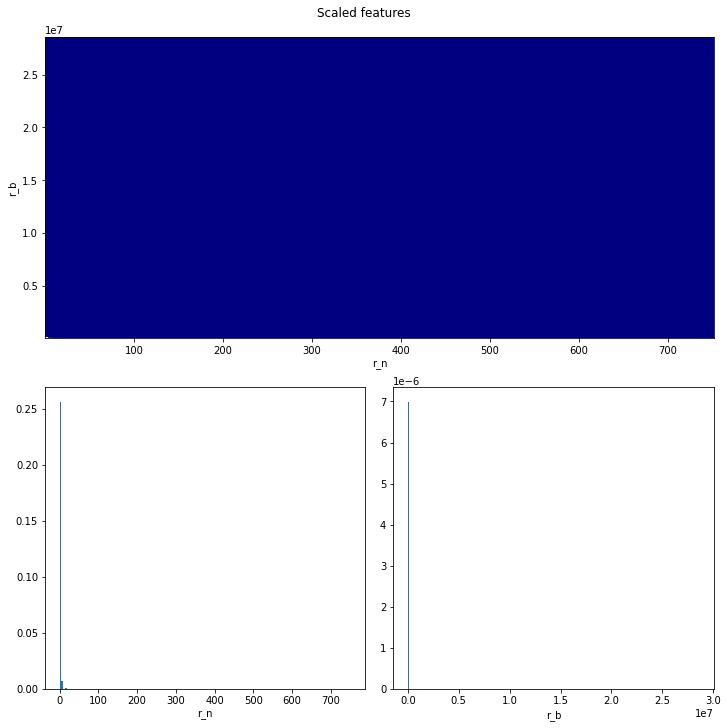

In [12]:
from plot_utils import plot_features

fig = plot_features(x_full, xlabel="r_n", ylabel="r_b")
plt.show()

Notice that `r_b` and `r_n` are concentrated around 0. Let's try transforming the data to make it easier to identify the classes.

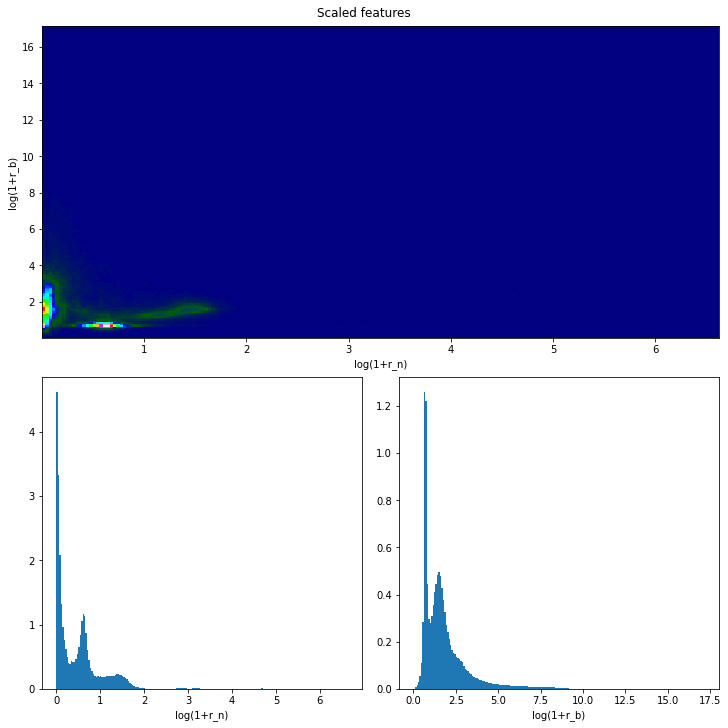

In [13]:
x_full = np.log(1+x_full)

fig = plot_features(x_full, xlabel="log(1+r_n)", ylabel="log(1+r_b)")
plt.show()

### Retrieving the labels
We compute the labels. Use the Shue1997 and Jerab2005 models for calculating the position of magnetopause and bow shock. Generating all the labels can take some time and we store the results in a local file to be reused on later executions.

In [14]:
# labels
labels_data_filename = data_filename.split(".")[0]+"_y.pkl"
if not os.path.exists(labels_data_filename):
    y_full = get_regions_dyn(sat_xyz,
                           sw_pdyn,
                           sw_b[:,2],
                           sw_n,
                           np.linalg.norm(sw_v, axis=1),
                           np.linalg.norm(sw_b, axis=1))
    pkl.dump(y_full, open(labels_data_filename,"wb"))
else:
    print(f"Loading labels from {labels_data_filename}")
    y_full = pkl.load(open(labels_data_filename, "rb"))


Loading labels from parameter_data_2007-03-01T00:00:00_2009-04-01T00:00:00_y.pkl


### Scalling the features

In [15]:
# scale the data
scaler = preprocessing.RobustScaler()
scaler.fit(x_full)
x_full = scaler.transform(x_full)

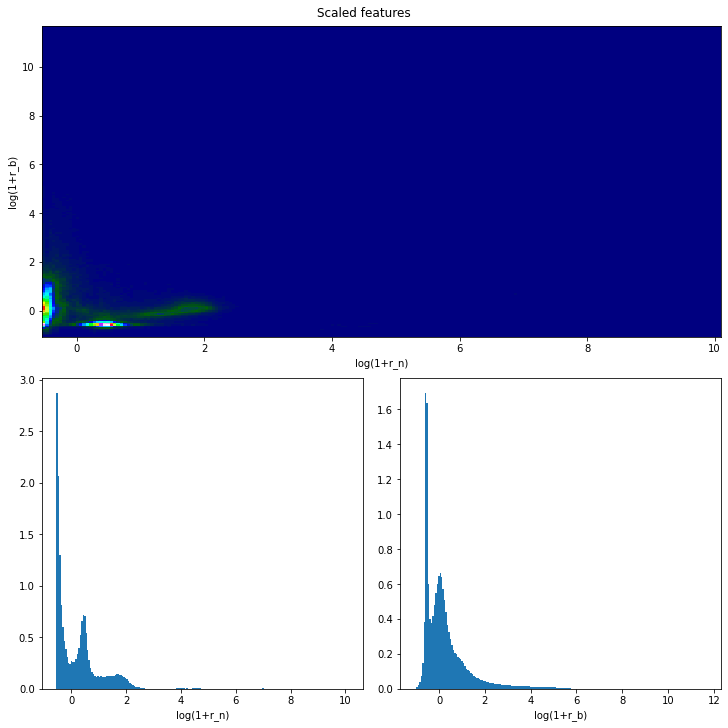

In [16]:
fig = plot_features(x_full, xlabel="log(1+r_n)", ylabel="log(1+r_b)", title="Scaled features")
plt.show()

## Train and testing data
Split the data in two sets used for training the detector and testing it.

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, xyz_train, xyz_test = train_test_split(x_full, y_full, sat_xyz)

print(f"Train data shape : {x_train.shape}")
print(f"Test data shape  : {x_test.shape}")

Train data shape : (815329, 2)
Test data shape  : (271777, 2)


View the resulting datasets.

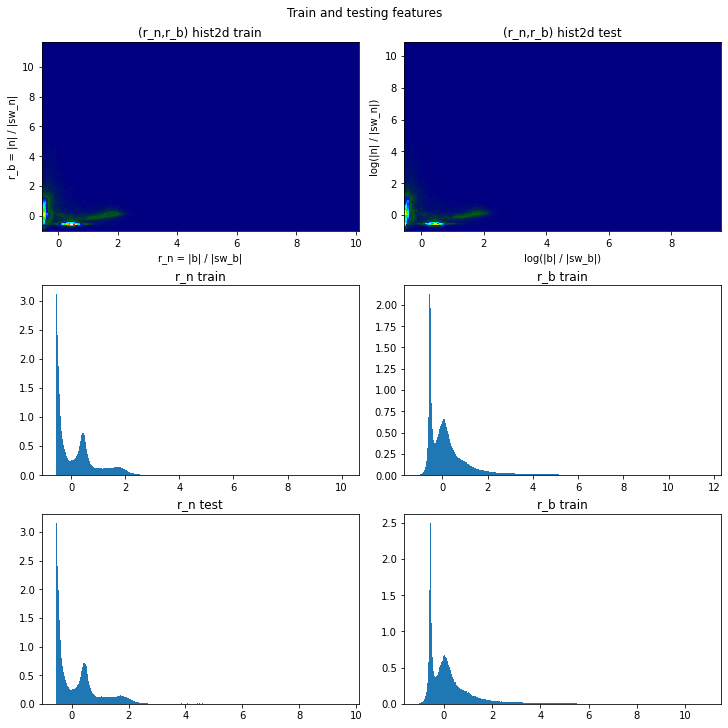

In [18]:
from plot_utils import plot_train_test_feature_densities, \
                       plot_train_test_label_densities, \
                       plot_clustering_result, \
                       plot_magnetosphere, \
                       plot_predicted_magnetosphere_region

fig = plot_train_test_feature_densities(x_train, x_test)
plt.show()

Check that the label distribution is the same in the testing and training datasets.

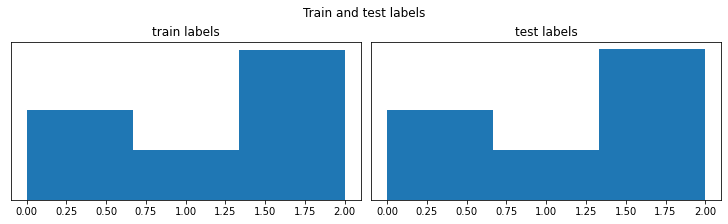

In [19]:
fig = plot_train_test_label_densities(x_train, x_test, y_train, y_test)
plt.show()

Metrics used for evaluating classifiers.

In [20]:
from sklearn.metrics import *

metrics =  [("accuracy_score",accuracy_score), 
            ("precision_score",lambda yt, y: precision_score(yt, y, average="macro")),
            ("recall_score",lambda yt, y: recall_score(yt, y, average="macro")),
            ("f1_score",lambda yt, y: f1_score(yt, y, average="macro")),
            ]

In [21]:
from sklearn.tree import DecisionTreeClassifier

class MagnetosphereRegionClassifier:
    def __init__(self, clf_f=DecisionTreeClassifier, clf_kwargs={}):
        self.clf_f = clf_f
        self.clf = clf_f(**clf_kwargs)
    def __str__(self):
        return f"MagnetosphereRegionClassifier(clf_f: {self.clf_f.__name__})"
    def fit(self, x, y):
        print("Fitting classifier")
        self.t_fit = time.time()
        r = self.clf.fit(x,y)
        self.t_fit = time.time() - self.t_fit
        return r
    def predict(self, x):
        return self.clf.predict(x)
    def scores(self, y_true, y_pred):
        return {n:m(y_true, y_pred) for n,m in metrics}
    def plot_prediction(self, x):
        pass
    def plot_results(self, x, y, xyz, class_labels):
        from plot_utils import plot_classification_results
        y_pred = self.predict(x)
        scores = self.scores(y, y_pred)
        return plot_classification_results(xyz, y, y_pred, xmin,xmax,ymin,ymax, 
                                           labels=class_labels,
                                          scores=scores,
                                          title=f"Classification results: {self.__str__}")
        

## Comparing classifiers
We start by defining the magnetosphere detector class. This class accepts a classifier method as input, creates an instance of that class on which is fitted the data. It provides an interface for generating prediction plots.

Let's try our detector with the default classification method : `DecisionTreeClassifier`.

In [22]:
# Decision tree classifier
rclf = MagnetosphereRegionClassifier()
rclf.fit(x_train, y_train)

Fitting classifier


DecisionTreeClassifier()

View the test results for the detector.

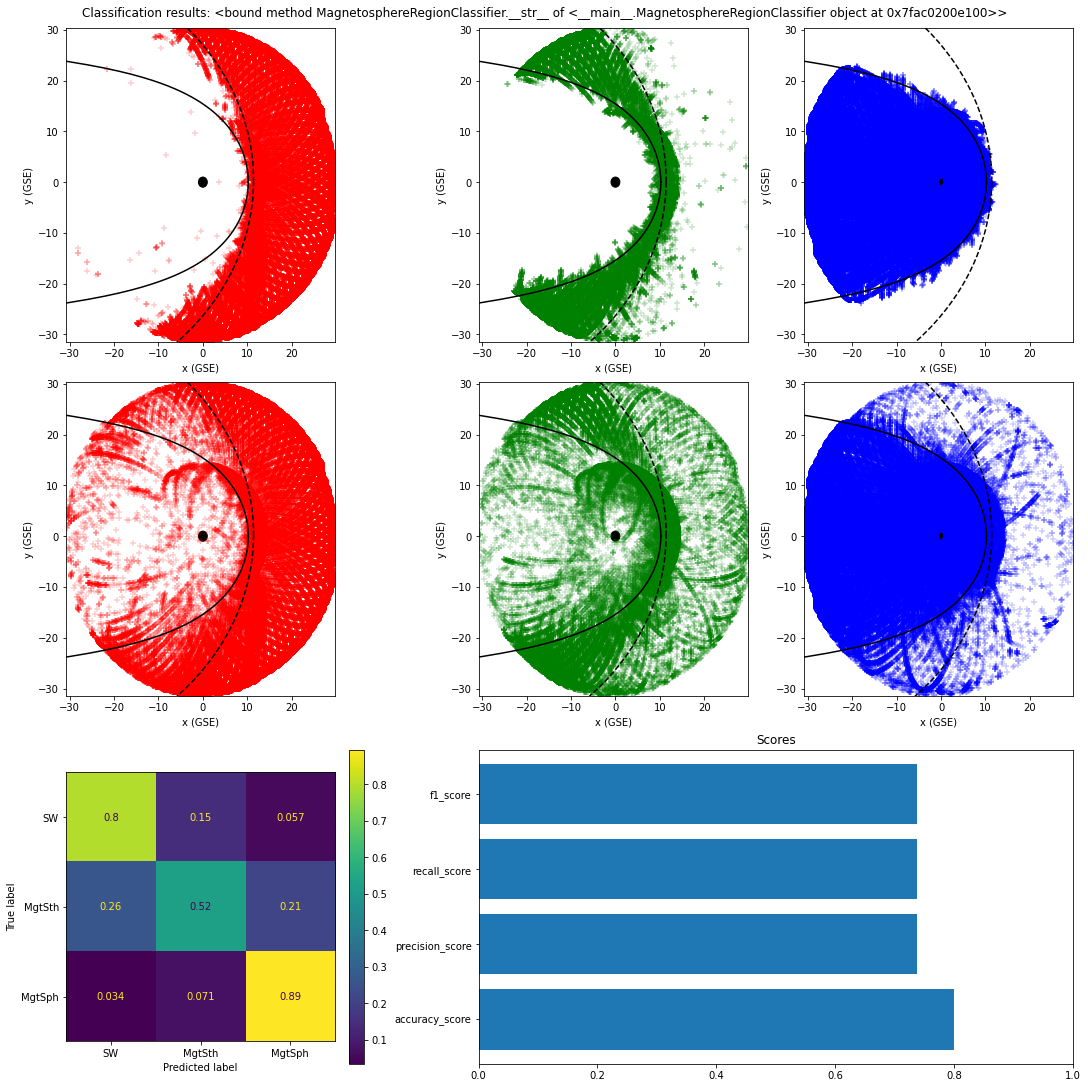

In [23]:
y_pred = rclf.predict(x_test)
    
fig = rclf.plot_results(x_test, y_test, xyz_test, 
                        class_labels=region_labels)
plt.show()

We will now compare various classifier provided by `sklearn`.

In [24]:
# Comparing classification methods
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier


classification_methods = [(KNeighborsClassifier,{"n_jobs":-1}),
                          SVC,
                          GaussianProcessClassifier,
                          DecisionTreeClassifier,
                          (RandomForestClassifier,{"n_jobs":-1}),
                          (MLPClassifier, {}),
                          AdaBoostClassifier,
                          GaussianNB,
                          QuadraticDiscriminantAnalysis
                        ]

The complexity of some of these methods precludes training over the whole training dataset. For these methods training is done on a smaller subset of the data.

In [25]:
slow_classifiers = {SVC:10000, 
                    GaussianProcessClassifier:3000,
                   }

In [26]:
scores = {}
region_classifiers = {}
for clf_f in classification_methods:
    if isinstance(clf_f, tuple):
        clf_kwargs = clf_f[1]
        clf_f = clf_f[0]
    else:
        clf_kwargs = {}
    print(f"Method: {clf_f.__name__}")
    rclf = MagnetosphereRegionClassifier(clf_f=clf_f, clf_kwargs=clf_kwargs)
    
    if clf_f in slow_classifiers:
        # these methods have at least quadratic complexity
        indx = np.random.choice(range(x_train.shape[0]),
                                size=slow_classifiers[clf_f])
        rclf.fit(x_train[indx], y_train[indx])
    else:
        rclf.fit(x_train, y_train)
    
    y_pred = rclf.predict(x_test)
    scores_tmp = rclf.scores(y_test, y_pred)
    scores[clf_f] = scores_tmp
    region_classifiers[clf_f]=rclf
    

Method: KNeighborsClassifier
Fitting classifier
Method: SVC
Fitting classifier
Method: GaussianProcessClassifier
Fitting classifier
Method: DecisionTreeClassifier
Fitting classifier
Method: RandomForestClassifier
Fitting classifier
Method: MLPClassifier
Fitting classifier
Method: AdaBoostClassifier
Fitting classifier
Method: GaussianNB
Fitting classifier
Method: QuadraticDiscriminantAnalysis
Fitting classifier


Training time for each method.

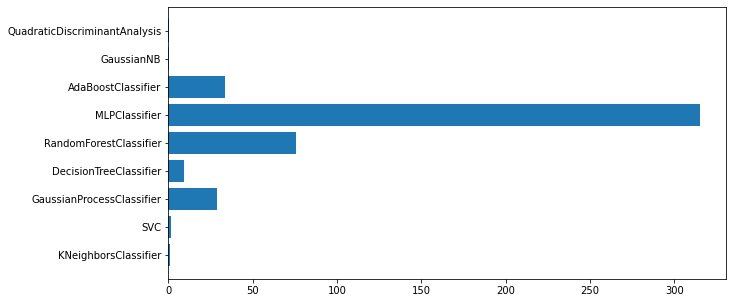

In [27]:
training_times = {clf_f: rclf.t_fit for clf_f, rclf in region_classifiers.items()}

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.barh(range(len(training_times)), list(training_times.values()))
ax.set_yticks(range(len(training_times)), [clf_f.__name__ for clf_f in training_times])
plt.show()

(10, 27)


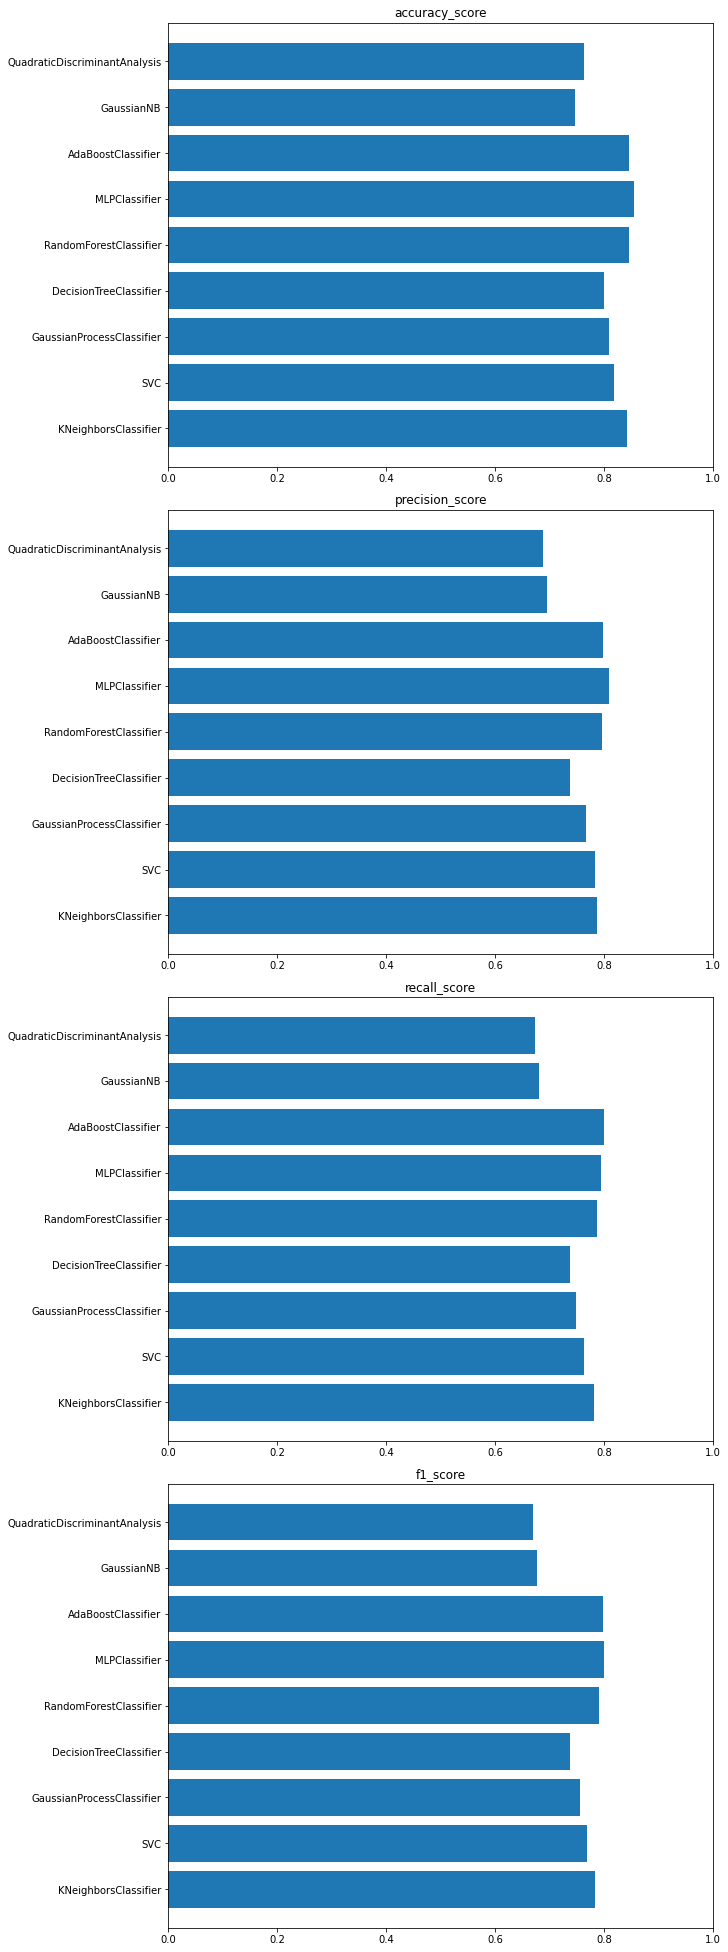

In [28]:
# plot scores
from plot_utils import plot_scores

fig = plot_scores(scores, metrics)
plt.show()

The best F1-score is obtained with `MLPClassifier`. Next we view the prediction results between 2008/05/12 08:00:00 and 2008/05/12 18:00:00

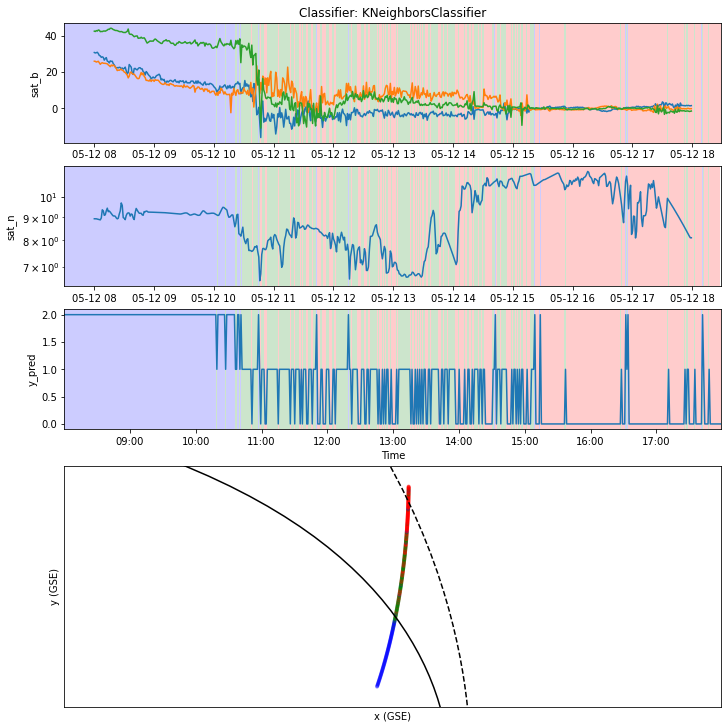

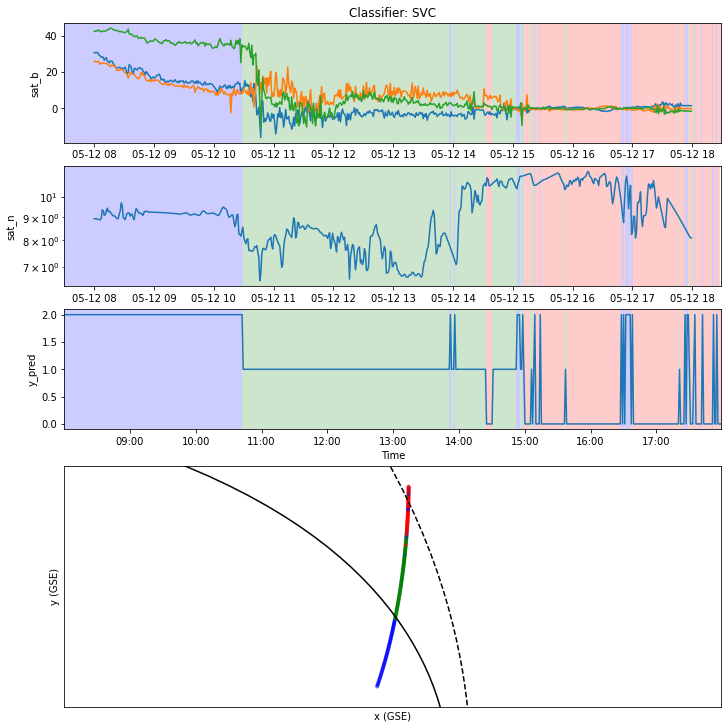

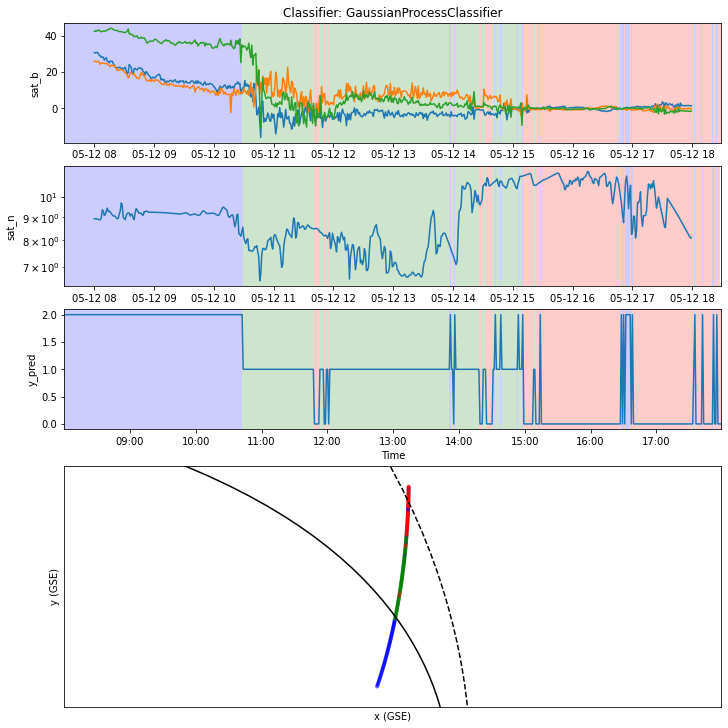

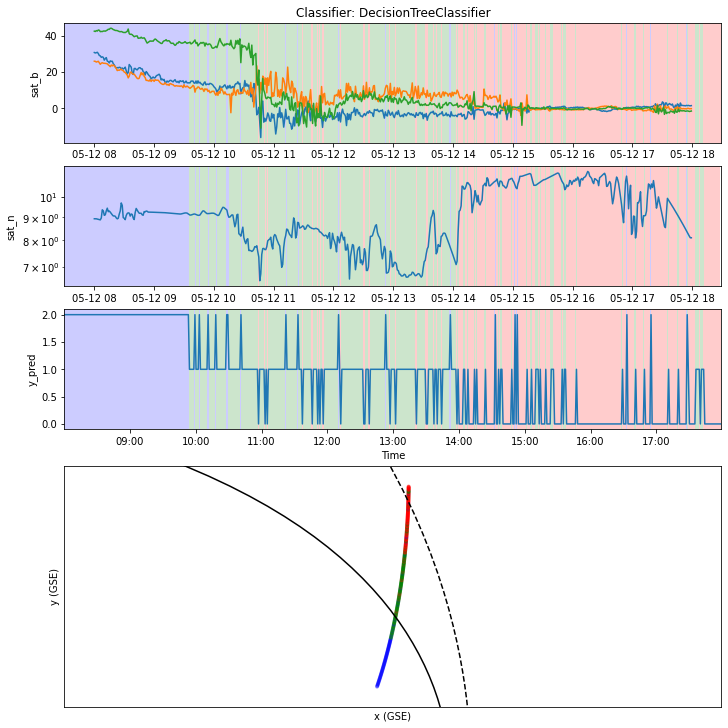

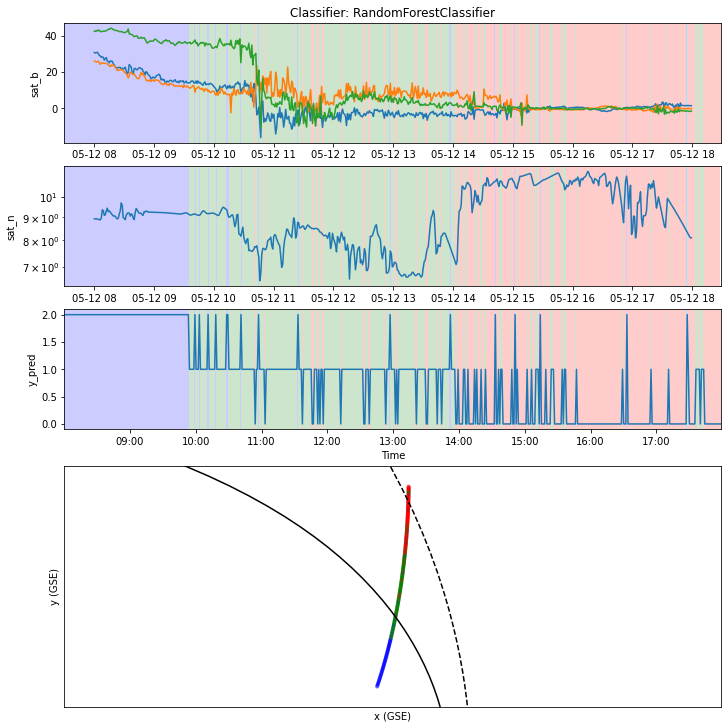

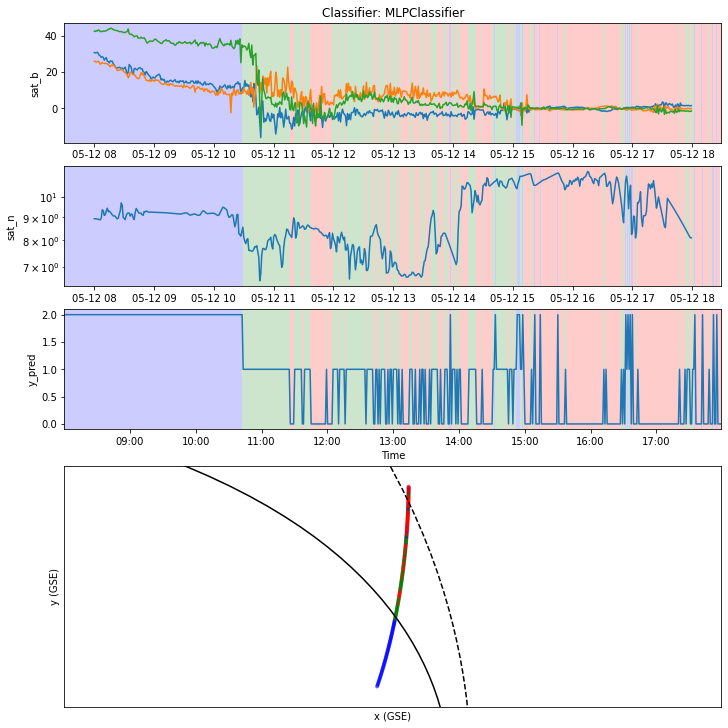

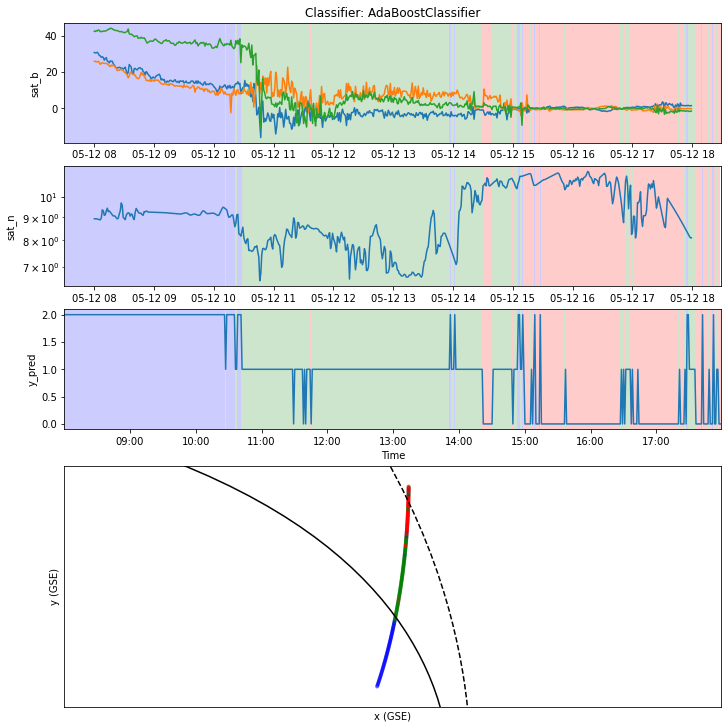

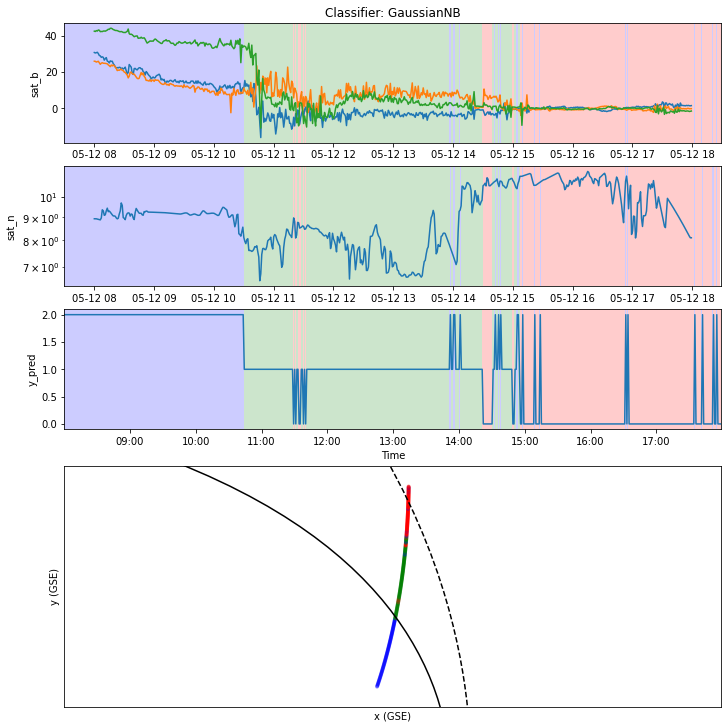

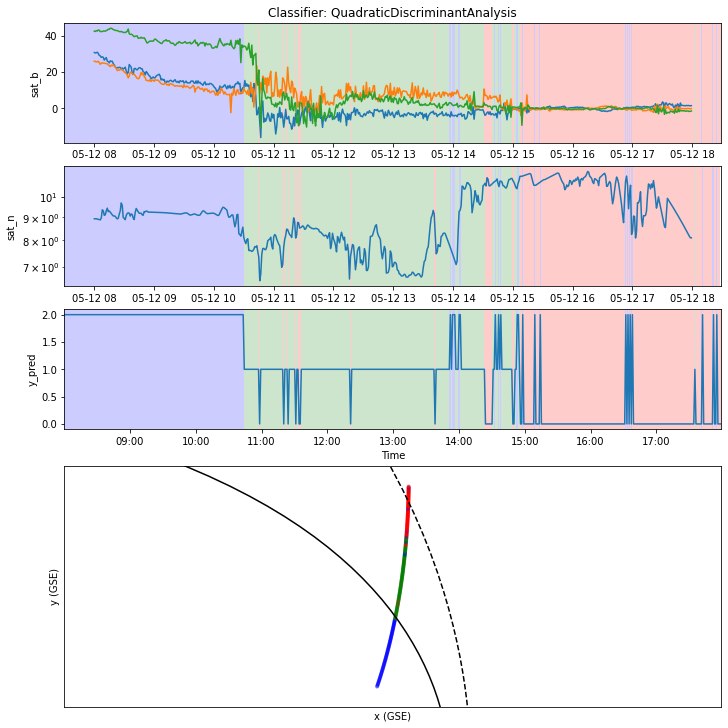

In [29]:
# Prediction
pred_start = datetime(2008, 5, 12, 8, 0, 0)
pred_stop = pred_start + timedelta(hours=10)

for method, clf in region_classifiers.items():
    fig_title = f"Classifier: {region_classifiers[method].clf_f.__name__}"
    plot_predicted_magnetosphere_region(pred_start, pred_stop, 
                                        t, x_full, sat_b, sw_n, sat_xyz,
                                     clf=clf,
                                     cmap=cmap,
                                    title=fig_title)
plt.show()

Plot the decision regions in the feature space.

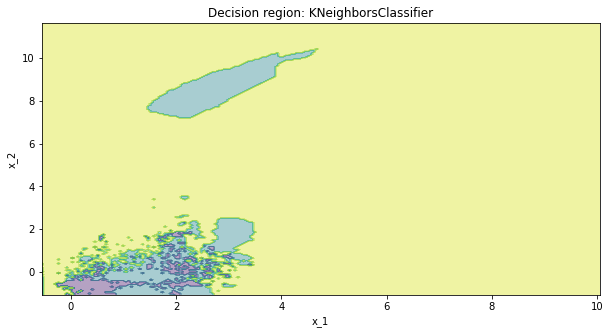

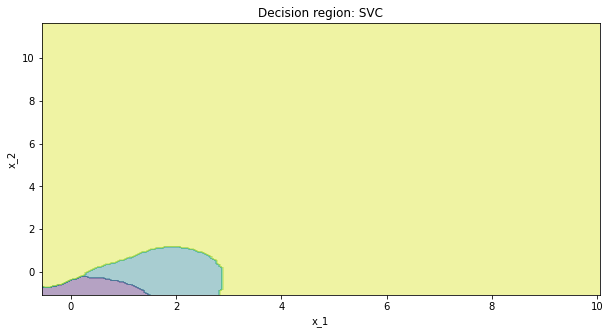

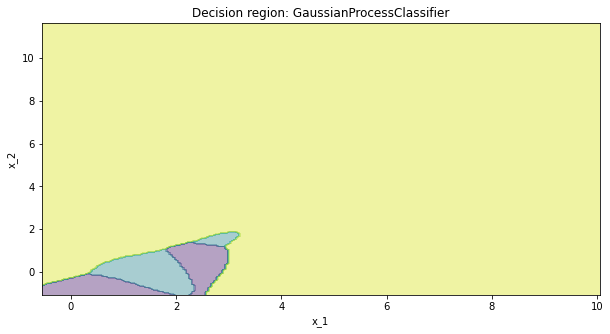

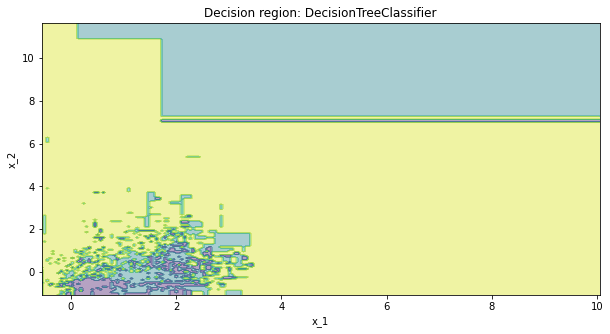

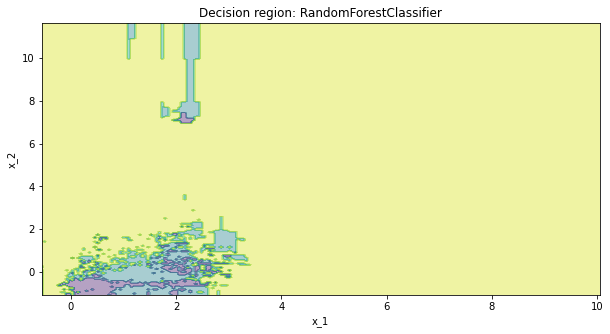

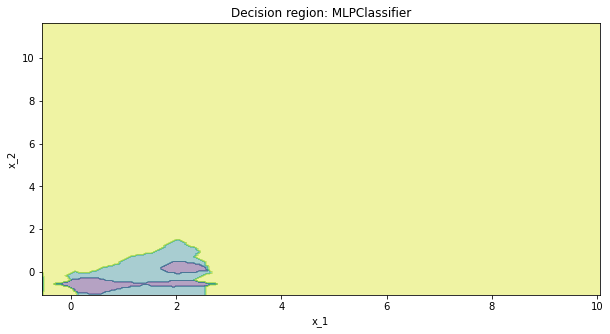

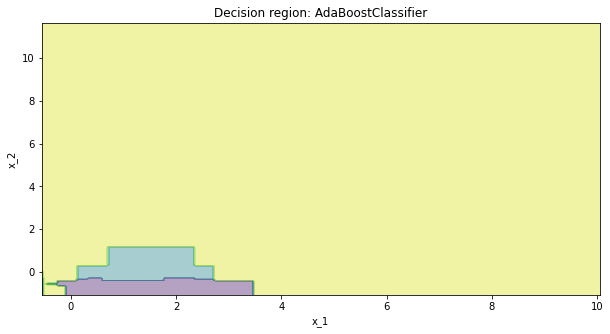

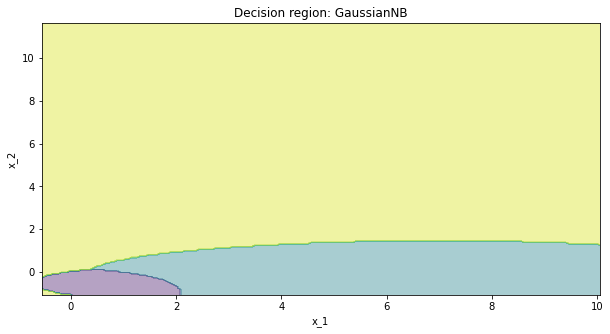

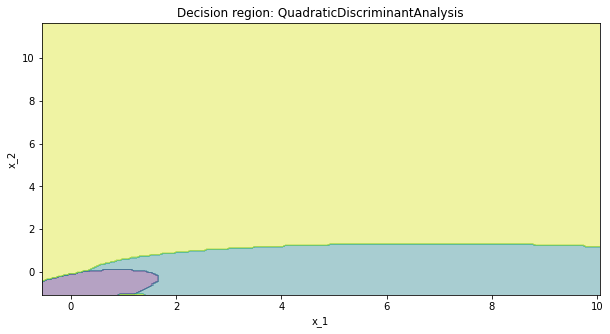

In [30]:
for method, clf in region_classifiers.items():
    fig, ax = plt.subplots(1,1,figsize=(10, 5))
    plt.title(f"Decision region: {method.__name__}")
    plot_decision_region(x_full, None, clf, ax)
    plt.xlabel("x_1")
    plt.ylabel("x_2")
plt.show()

## Clustering
Previous datasets rely on Shue and Jerab models to compute the labels. These models are approximations of the truth and thus the trained detector is inherently biased. 

We work under the assumption that each class is characterized by a region of the feature space. Errors occur for the most part on the boundaries of these regions.

In this next section we use clustering to determine a subset of samples that are in the *interior* of each characteristic region of the feature space.

In [31]:
from sklearn.cluster import SpectralClustering, KMeans, OPTICS, Birch,AgglomerativeClustering
from cluster_utils import cluster_test

Define a new detector that first clusters the data and then fits the classifier.

In [32]:
class MagnetosphereRegionClusterClassifier(MagnetosphereRegionClassifier):
    def __init__(self, clust_f=KMeans, clust_kwargs={}, 
                 clf_f=DecisionTreeClassifier, clf_kwargs={},
                n_clusters=5, tol=.98):
        super().__init__(clf_f, clf_kwargs)
        self.clust_f = clust_f
        self.clust = clust_f(**clust_kwargs)
        self.n_clusters = n_clusters
        self.tol = tol
    def fit(self, x, y):
        # clustering
        f,l,pos = cluster_test(x, y, x, 
                               method=self.clust_f, 
                               n_clusters=self.n_clusters, 
                               tol=self.tol)
        if (f is None) or (l is None):
            raise Exception("Failed to cluster")
        # classification
        super().fit(f, l)
        return self

List of clustering methods.

In [36]:
from sklearn.cluster import SpectralClustering, KMeans, MiniBatchKMeans, OPTICS, Birch,AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift

cluster_methods = [KMeans, 
                   #MiniBatchKMeans,
                   #SpectralClustering, # bad
                   #OPTICS, 
                   #DBSCAN, 
                   Birch, 
                   #AgglomerativeClustering,
                   #GaussianMixture,
                   #MeanShift
              ]

As with the classifiers, some clustering methods are slow.

In [37]:
slow_methods = [SpectralClustering, AgglomerativeClustering,OPTICS]


In [38]:



region_classifiers = {}
for method in cluster_methods:
    if isinstance(method, tuple):
        clust_kwargs = method[1]
        method = method[0]
    else:
        clust_kwargs = {}
    print(f"Method: {method.__name__}")
    rclf = MagnetosphereRegionClusterClassifier(clust_f=method,
                                                clust_kwargs=clust_kwargs,
                                               clf_f=MLPClassifier)
    
    if method in slow_methods:
        # these methods have at least quadratic complexity
        indx = np.random.choice(range(x_train.shape[0]),size=4000)
        rclf.fit(x_train[indx], y_train[indx])
    else:
        rclf.fit(x_train, y_train)

    fy_pred = rclf.predict(x_test)
    scores_tmp = rclf.scores(y_test, y_pred)
    scores[clf_f] = scores_tmp
    region_classifiers[clf_f]=rclf


Method: KMeans
Fitting classifier
Method: Birch


ValueError: Found array with 1 sample(s) (shape=(1, 2)) while a minimum of 2 is required by AgglomerativeClustering.

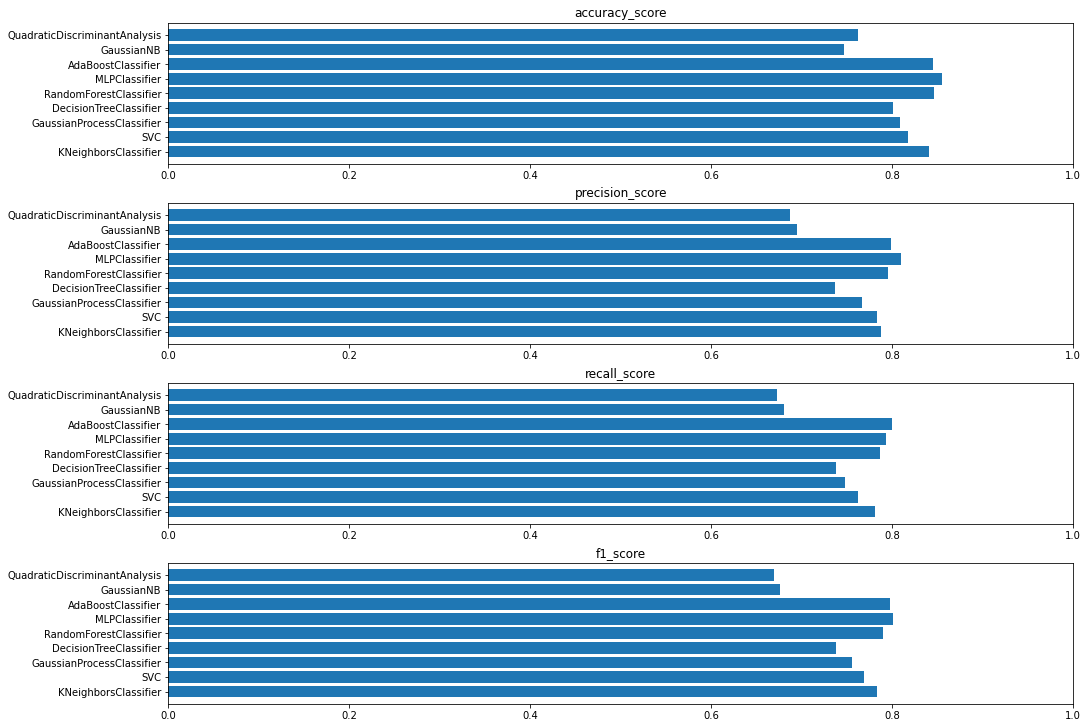

In [40]:
# plot scores
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(len(metrics), 1, figure=fig)

method_labels = [m.__name__ for m in scores.keys()]
ax0 = None
for i,(n,m) in enumerate(metrics):
    if ax0 is None:
        ax = fig.add_subplot(gs[i,0])
        ax0 = ax
    else:
        ax = fig.add_subplot(gs[i,0], sharex=ax0)
    ax.set_title(n)
    # score values
    ax.barh(range(len(scores)), [s[n] for s in scores.values()])
    
    ax.set_yticks(range(len(scores)), method_labels)
    
    ax.set_xlim(0,1)
plt.show()

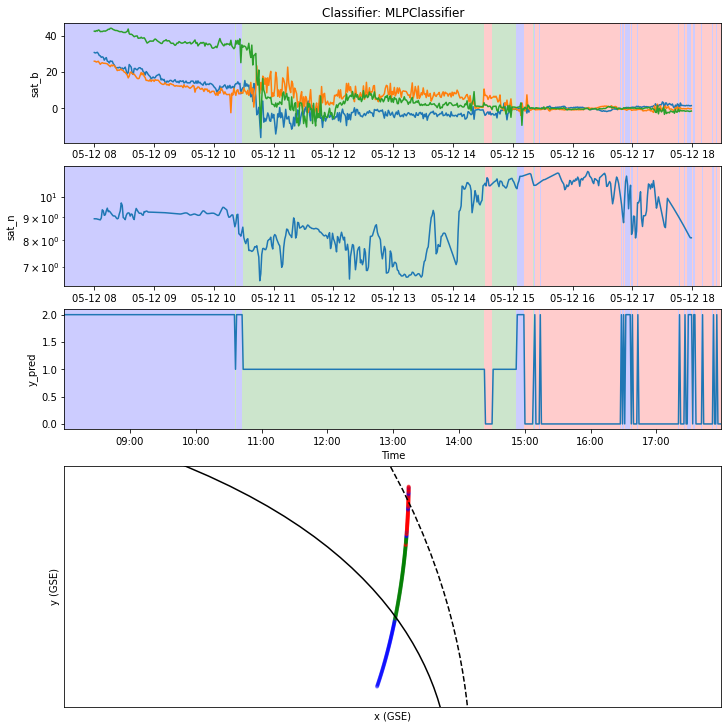

In [41]:
# Prediction
pred_start = datetime(2008, 5, 12, 8, 0, 0)
pred_stop = pred_start + timedelta(hours=10)

for method in region_classifiers:
    fig_title = f"Classifier: {region_classifiers[method].clf_f.__name__}"
    plot_predicted_magnetosphere_region(pred_start, pred_stop, 
                                        t, x_full, sat_b, sw_n, sat_xyz,
                                     clf=region_classifiers[method],
                                     cmap=cmap,
                                    title=fig_title)
plt.show()

In [ ]:
raise KeyboardInterrupt